# Genetic algorithm: Rucksackproblem

In diesem Beispiel soll das sogenannte Rucksackproblem gelöst werden.
Eine Menge von Gegenständen, die jeweils ein Gewicht und einen Nutzwert haben, sollen in einen Rucksack gepackt werden, der eine maximale Traglast hat.
Da der Rucksack nicht für alle Objekte ausreicht, kann nur ein Teil davon eingepackt werden.
Der Nutzwert der gewählten Sachen soll maximiert werden, ohne die Maximallast zu übersteigen.

Genetische Algorithmen können hierfür eine Lösung sein.
Diese Algorithmen basieren auf Darwins Theorie 'survival of the fittest'. Hierbei werden, ähnlich wie bei der Evolution, jeweils 2 Lösungsvorschläge miteinander kombiniert, sodass ein neuer Lösungsvorschlag entsteht. Durch das Wiederholen dieses Vorgangs entstehen mehrere Generationen von Lösungsvorschlägen. Zusätzlich wird jede Generation zufällig verändert (Mutation).

Folgendes Ablaufdiagramm veranschaulicht die Schritte, die in diesem Beispiel durchgeführt werden:

![alt text](Flowchart.png "Title")

In [27]:
import numpy as np
import pandas as pd
import random as rd
from random import randint
import matplotlib.pyplot as plt
import ipywidgets as wg
from IPython.display import display

In [28]:
print('Anzahl der Gegenstände:')
inum = wg.IntSlider( value=10,min=1, max=35)
display(inum)

print('Größe des Rucksacks:')
kw = wg.IntSlider(value=35,min=1, max=55)
display(kw)

Anzahl der Gegenstände:


IntSlider(value=10, max=35, min=1)

Größe des Rucksacks:


IntSlider(value=35, max=55, min=1)

### Generieren einer Liste von Gegenständen

Die generierten Gegenstände erhalten die Attribute Gewicht (weight) und Wert (value).
'knapsack_treshold' gibt hierbei die maximale Traglast des Rucksacks an.

In [29]:
# Generieren zufälliger Gegenstände
item_number = np.arange(1,inum.value+1)
weight = np.random.randint(1, 15, size = inum.value) # Gewicht der Gegenstände
value = np.random.randint(10, 750, size = inum.value) # Wert der Gegenstände
knapsack_threshold = kw.value # Größe des Rucksacks
print('Gegenstandsliste:')
print('#Gegenstand   Gewicht   Nutzwert')
for i in range(item_number.shape[0]):
    print('{0}          {1}         {2}\n'.format(item_number[i], weight[i], value[i]))

Gegenstandsliste:
#Gegenstand   Gewicht   Nutzwert
1          14         536

2          2         741

3          4         306

4          1         693

5          9         42

6          8         472

7          1         282

8          6         615

9          10         638

10          7         556



### Erstellen der Anfangspopulation

Die Chromosomen in diesem  Beispiel bestehen aus genau so vielen Genen wie es Gegenstände gibt.
Jedes Gen kann dabei den Wert 1 oder 0 haben - der Gegenstand ist also im Rucksack enthalten oder nicht.

![alt text](Chromosomen.PNG "Title")

In [30]:
print('Anzahl der Generationen:')
ng = wg.IntSlider( value=50,min=1, max=100)
display(ng)
print('Größe der Population:')
sol = wg.IntSlider( value=8,min=1, max=25)
display(sol)

Anzahl der Generationen:


IntSlider(value=50, min=1)

Größe der Population:


IntSlider(value=8, max=25, min=1)

In [31]:
# Erstellen der Anfangspopulation
solutions_per_pop = sol.value
pop_size = (solutions_per_pop, item_number.shape[0])
print('Population size = {}'.format(pop_size))
initial_population = np.random.randint(2, size = pop_size)
initial_population = initial_population.astype(int)
num_generations = ng.value
print('Initial population: \n{}'.format(initial_population))

Population size = (8, 10)
Initial population: 
[[1 1 1 1 0 1 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 1 0 1 1 0 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 1 1]
 [1 1 0 0 1 0 0 0 1 1]
 [1 1 1 0 1 0 1 1 0 1]
 [1 1 1 1 0 0 0 1 0 0]]


### Fitness Measure

Die Fitnessfunktion ordnet jedem Lösungsvorschlag einen 'fitness score' zu, um es bezüglich seiner Qualität zu bewerten. Dieser Wert ist die Grundlage
für die Entscheidung, ob ein Lösungsvorschlag für die Reproduktion ausgewählt wird.

Die Fitnessfunktion, die für dieses Problem genutzt wird, ist folgende:
![alt text](Formel.PNG "Title")

mit:
n = Länge der Chromosomen
c_i = Gen an Stelle i
v_i = Wert an Stelle i
w_i = Gewicht an Stelle i
kw = maximale Traglast des Rucksacks


In [32]:
def cal_fitness(weight, value, population, knapsack_threshold):
    fitness = np.empty(population.shape[0])
    for i in range(population.shape[0]):
        S1 = np.sum(population[i] * value)
        S2 = np.sum(population[i] * weight)
        if S2 <= knapsack_threshold:
            fitness[i] = S1
        else :
            fitness[i] = 0
    return fitness.astype(int)

### Selection

Hier werden die "besten" Lösungsvorschläge für den nächsten Schritt ausgewählt.

In [33]:
def selection(fitness, num_parents, population):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

### Crossover

Das Crossover ist der wichtigste Teil von genetischen Algorithmen. Für jedes Elternpaar wird ein 'crossover point' gewählt (in diesem Fall in der Mitte
 des Chromosoms).

zur Veranschaulichung ein Beispiel mit sechs Genen und dem 'crossover point' an der dritten Stelle:

![alt text](Crossover%20Point.png "Title")

Für die Nachkommen werden die einzelnen Gene vertauscht, bis der 'crossover point' erreicht ist:

![alt text](Exchange.png "Title")

Die Nachkommen sehen aus wie folgt:

![alt text](Offspring.png "Title")

In [34]:
def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = rd.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings

### Mutation

In diesem Schritt werden zufällig einzelne Gene gewählt, die mutieren - bei denen sich also der Wert ändert.
Dieses Beispiel verwendet die 'bit-flip' Technik. Hat ein, für die Mutation ausgewähltes, Gen den Wert 1, wird dieser mit 0 ersetzt und umgekehrt.

In [35]:
def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = rd.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)
        if mutants[i,int_random_value] == 0 :
            mutants[i,int_random_value] = 1
        else :
            mutants[i,int_random_value] = 0
    return mutants

### Initialisierung

Alle Funktionen wurden definiert und werden nun in der Reihenfolge des Ablaufdiagramms abgerufen. Dadurch finden wir die erforderlichen Parameter
und können die notwendigen Initialisierungen durchführen.

In [36]:
def optimize(weight, value, population, pop_size, num_generations, threshold):
    parameters, fitness_history = [], []
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents
    for i in range(num_generations):
        fitness = cal_fitness(weight, value, population, threshold)
        fitness_history.append(fitness)
        parents = selection(fitness, num_parents, population)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants

    print('Letzte Generation: \n{}\n'.format(population))
    fitness_last_gen = cal_fitness(weight, value, population, threshold)
    print('Fitness der letzten Generation: \n{}\n'.format(fitness_last_gen))
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    parameters.append(population[max_fitness[0][0],:])
    return parameters, fitness_history

### Ergebnis

Der Nachwuchs mit der besten 'fitness' ist gefunden.
Die Stellen mit dem Wert 1 geben an, welche Gegenstände mitgenommen werden.

In [37]:
parameters, fitness_history = optimize(weight, value, initial_population, pop_size, num_generations, knapsack_threshold)
print('Die optimierten Parameter sind: \n{}'.format(parameters))
selected_items = item_number * parameters
print('\nGewählte Kombination aus Gegenständen mit größtmöglichem Nutzwert, ohne den Rucksack zu überlasten:')
for i in range(selected_items.shape[1]):
  if selected_items[0][i] != 0:
     print('{}\n'.format(selected_items[0][i]))

Letzte Generation: 
[[1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]
 [1 1 0 1 0 0 1 1 1 0]]

Fitness der letzten Generation: 
[3505 3505 3505 3505 3505 3505 3505 3505]

Die optimierten Parameter sind: 
[array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])]

Gewählte Kombination aus Gegenständen mit größtmöglichem Nutzwert, ohne den Rucksack zu überlasten:
1

2

4

7

8

9



### Visualisierung

Diese Visualisierung zeigt, wie sich die 'fitness' mit jeder Generation verändert hat.

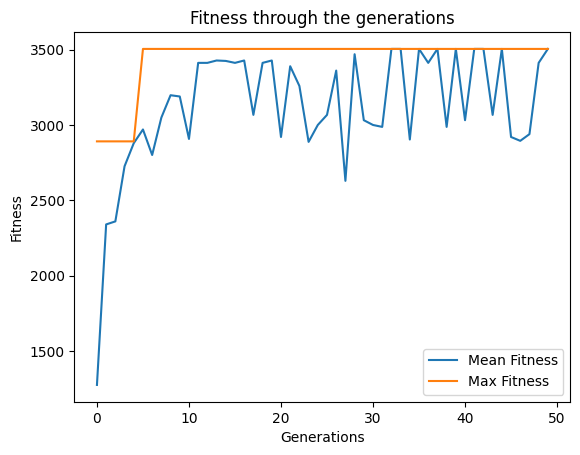

(50, 8)


In [38]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()
print(np.asarray(fitness_history).shape)

Quellen:
https://medium.com/koderunners/genetic-algorithm-part-1-intuition-fde1b75bd3f9
https://medium.com/koderunners/genetic-algorithm-part-3-knapsack-problem-b59035ddd1d6
https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3#:~:text=A%20genetic%20algorithm%20is%20a,offspring%20of%20the%20next%20generation.